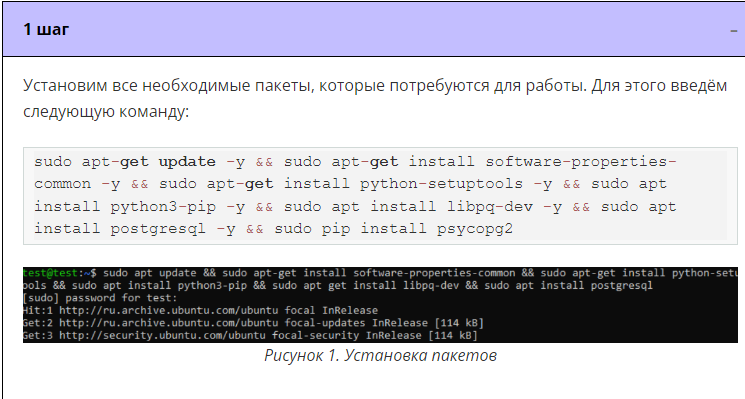

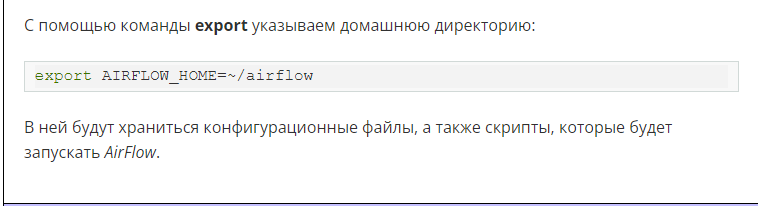

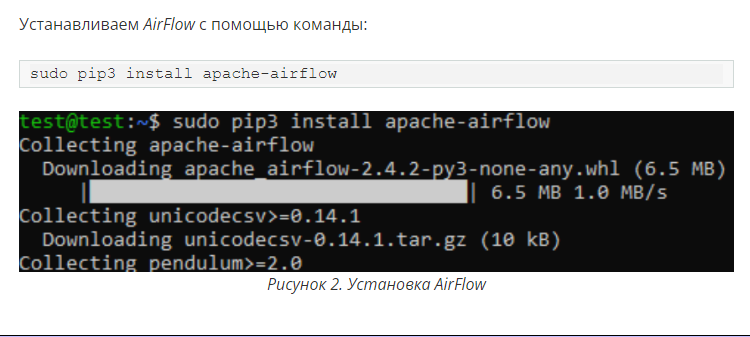

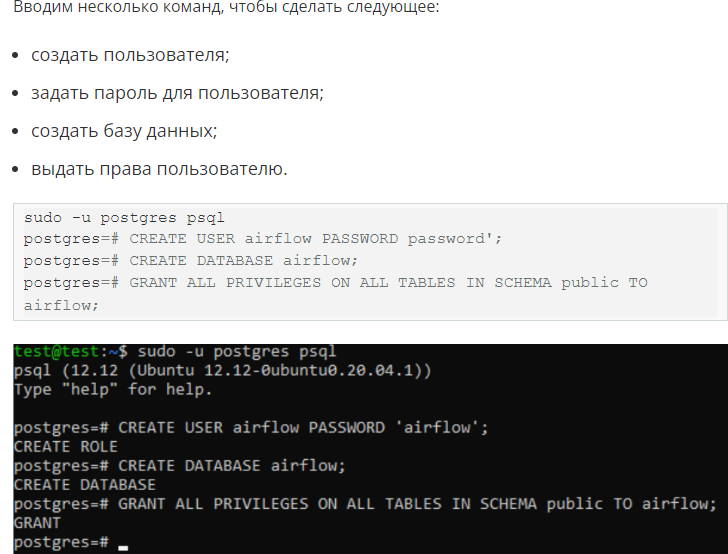

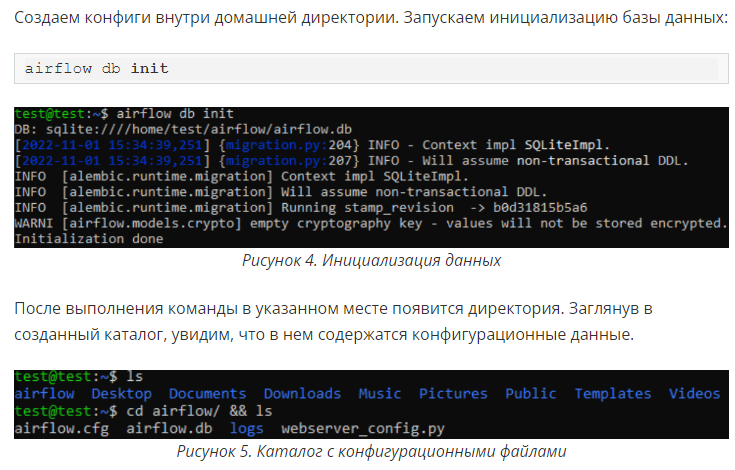

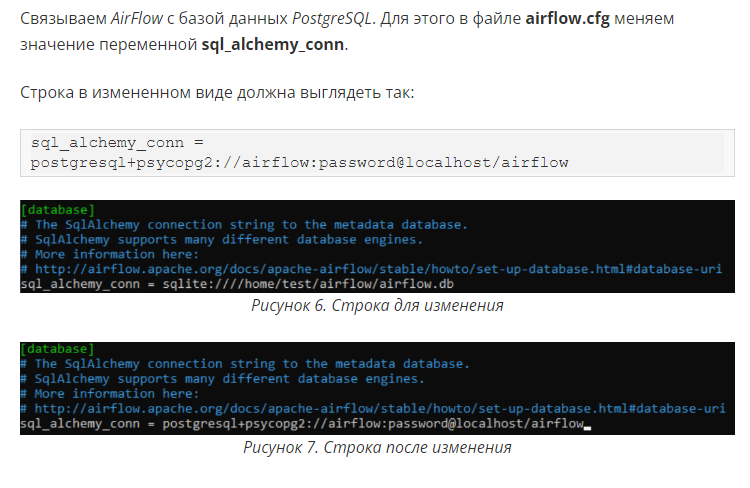

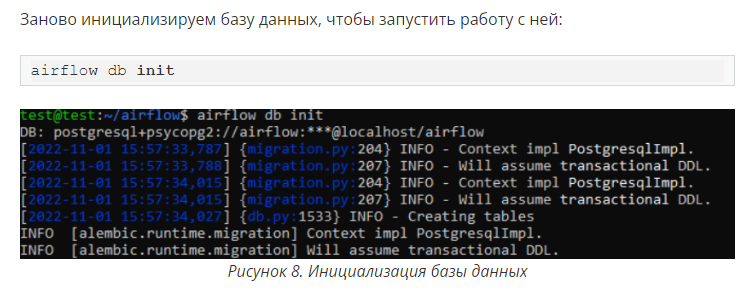

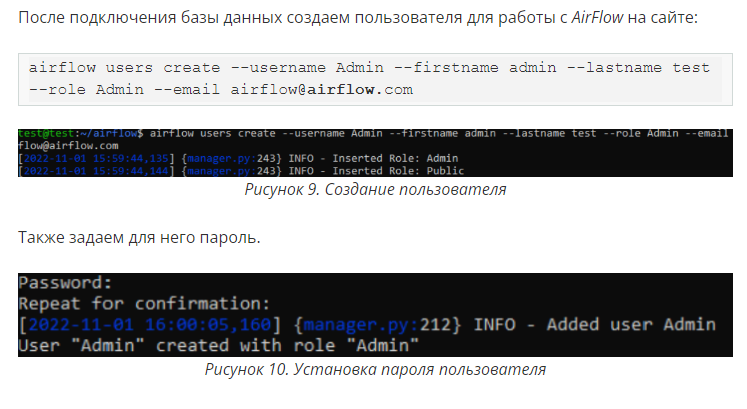

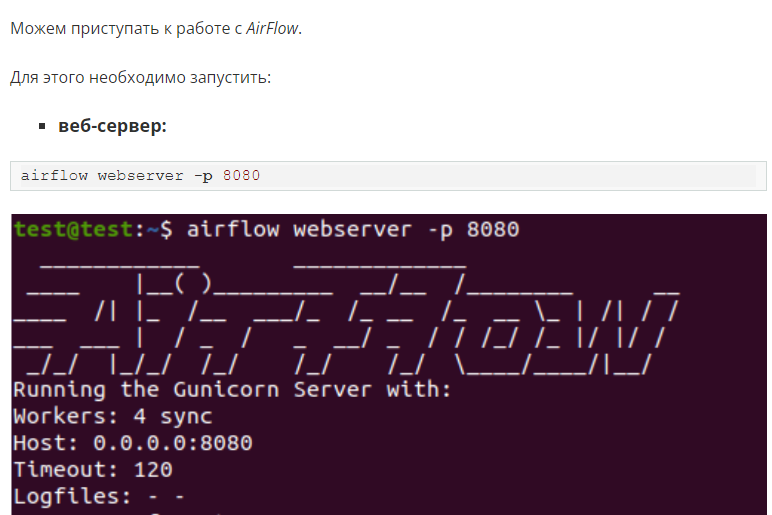

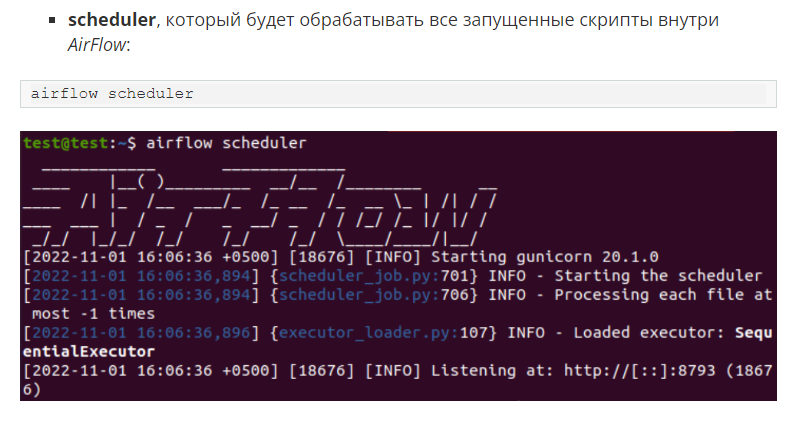

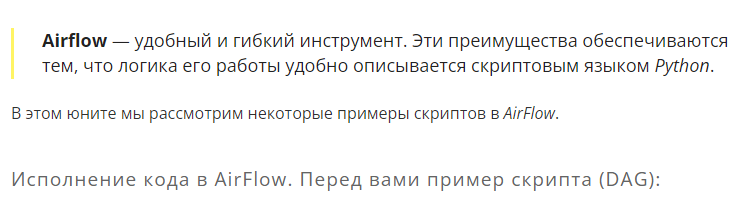

In [ ]:
from airflow import DAG
import airflow
from datetime import datetime
from airflow.operators.python import PythonOperator

def test123():
    print("Hello world!")

args = {
    'owner': 'dimon',
    'start_date':datetime(2018, 11, 1),
    'provide_context':True
}

with DAG('Hello-world_example', description='Hello-world example', schedule_interval='*/1 * * * *',  catchup=False, default_args=args) as dag:
    task_1 = PythonOperator(task_id="task_1", python_callable=test123)

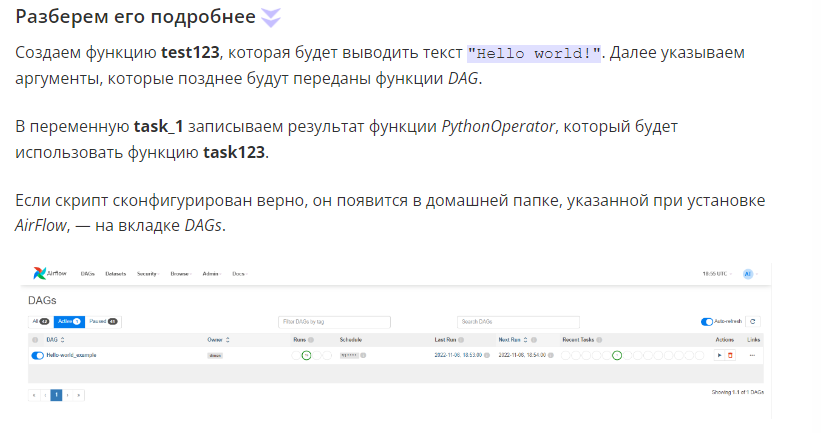

Если открыть конкретный DAG, можно увидеть прогресс выполнения при каждом запуске скрипта.

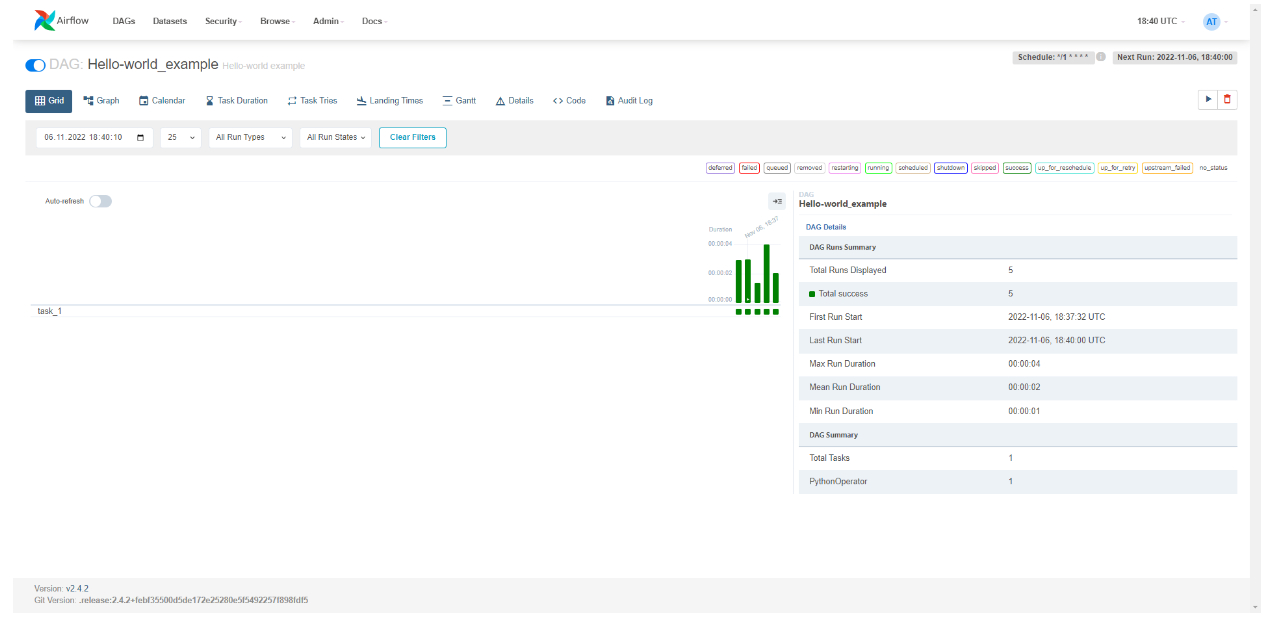

азберем, какая еще информация о DAG доступна в этом разделе:
Во вкладке Code можно посмотреть код исполняемого DAG.

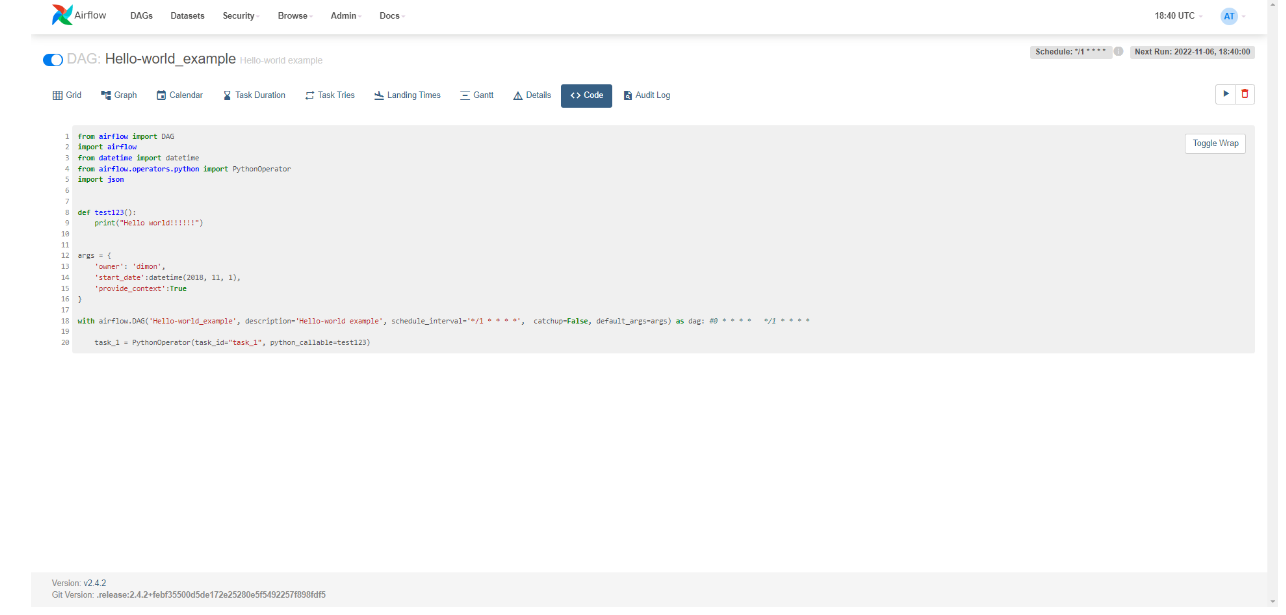

На вкладке Log можно посмотреть состояние программы, например, при выводе текста во время ее выполнения.

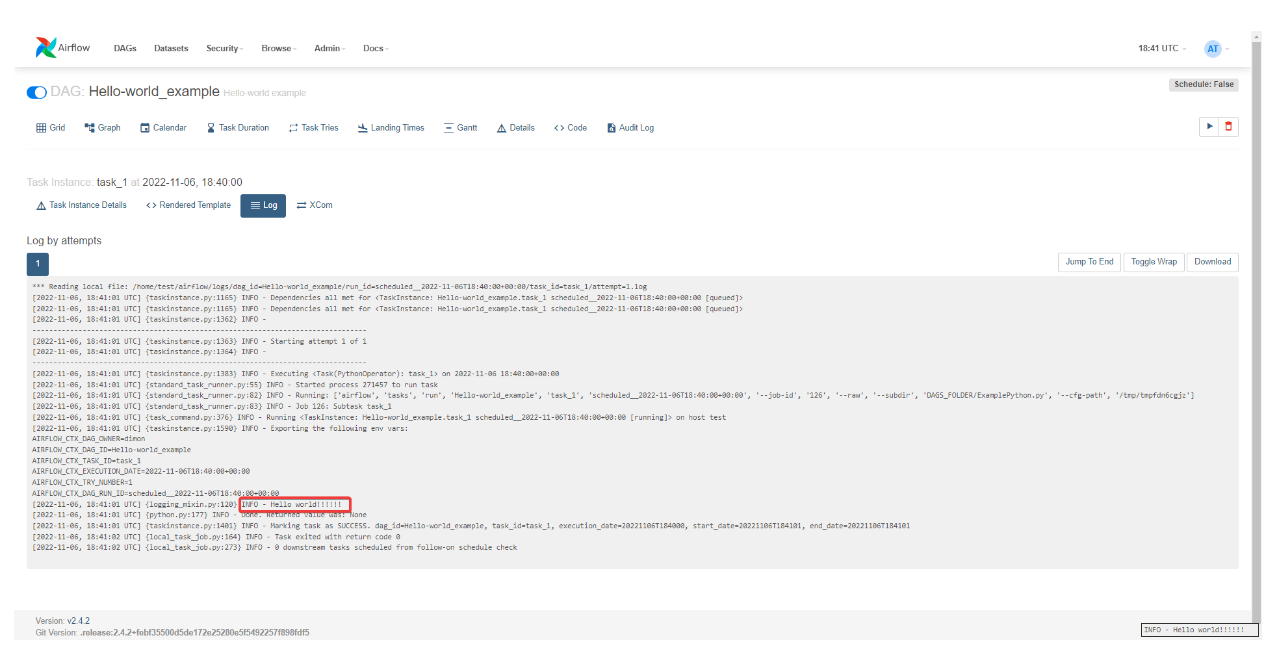

На вкладке Graph можно увидеть последовательность выполнения программы.

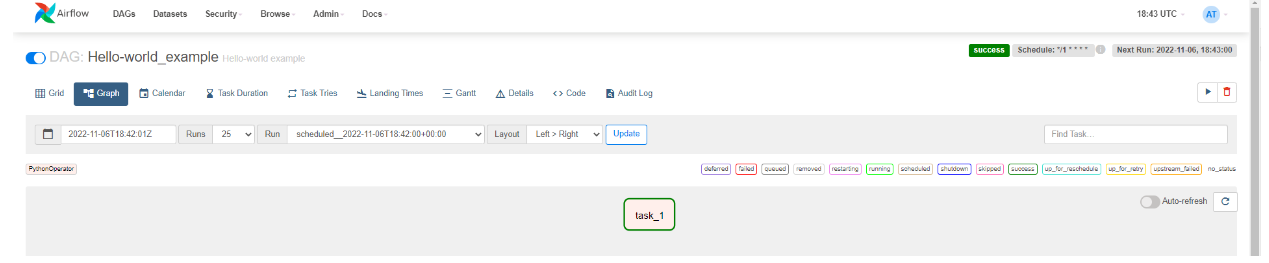

In [ ]:
from airflow import DAG
import airflow
from datetime import datetime
from airflow.operators.python import PythonOperator
from airflow.operators.bash import BashOperator
import json

args = {
    'owner': 'dimon',
    'start_date':datetime(2018, 11, 1),
    'provide_context':True
}

with airflow.DAG('LS_Bash_example', description='Hello-world example', schedule_interval='*/1 * * * *',  catchup=False, default_args=args) as dag: #0 * * * *   */1 * * * *

    task_1 = BashOperator(task_id="task_1", bash_command="ls -la ~/airflow/dags")

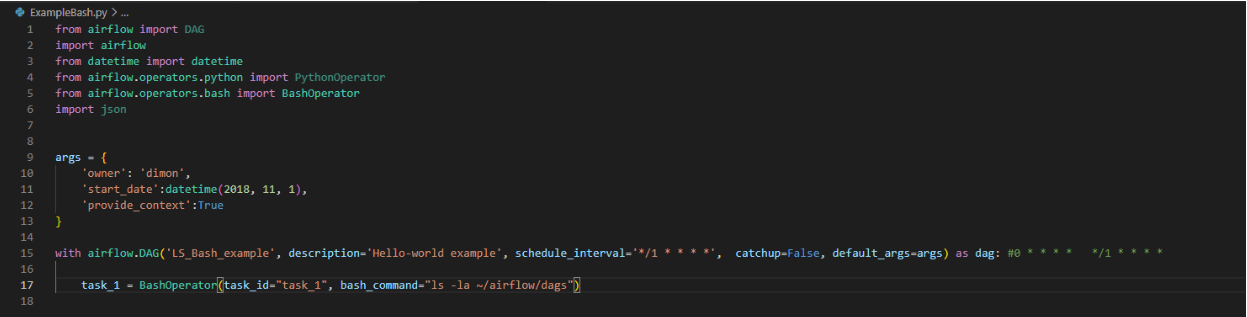

Результат выполнения Bash-скрипта выводится в log.

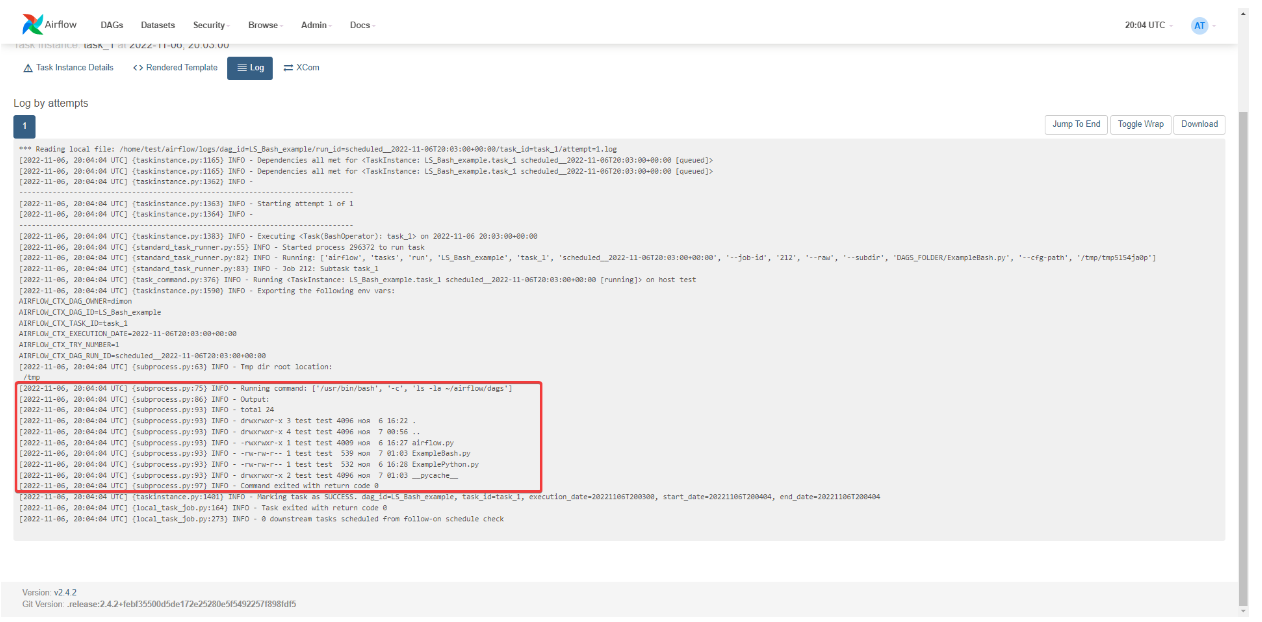

сли команда завершилась из-за ошибки (например, файл не найден), то в графическом интерфейсе маркер, обозначающий выполнение заданного шага, будет красного цвета.

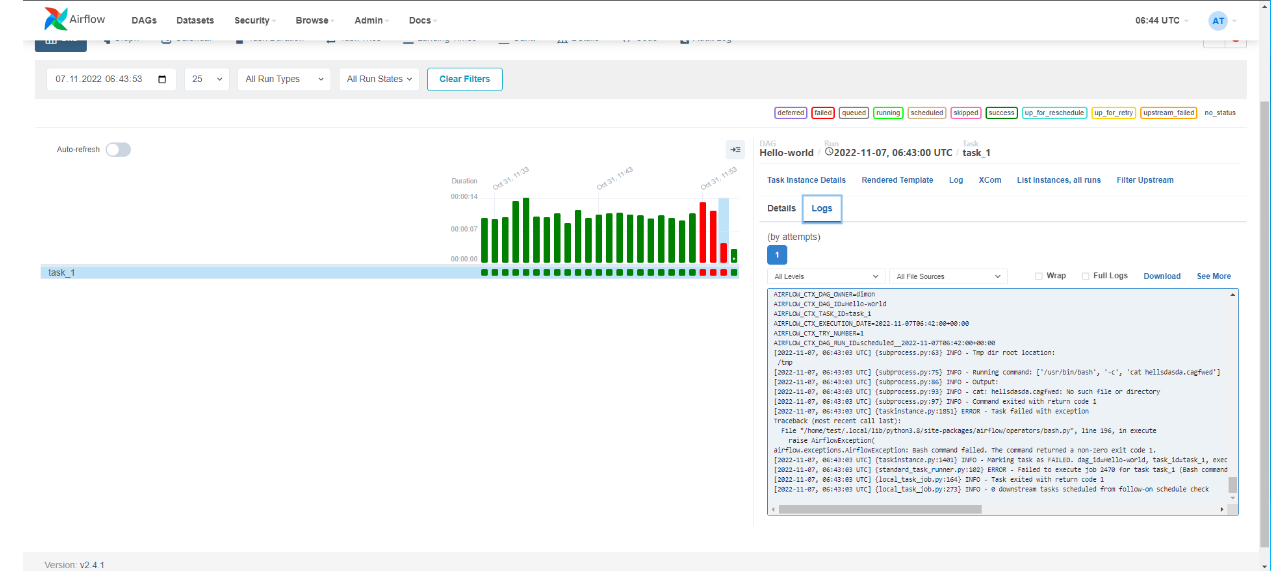

В этом юните вы рассмотрите пример работы с AirFlow.

Перед вами скрипт, реализующий модель линейной регрессии с разным количеством регрессоров, которое зависит от параметра:

In [ ]:
from airflow import task, DAG
from datetime import datetime, timedelta
import airflow
from airflow.operators.python import PythonOperator
import json

def StepOne(ti):
    from random import randint
    import numpy as np
    from sklearn.model_selection import train_test_split

    #ti = kwargs["ti"]
    xs = np.linspace(0, 10, 50)
    ys = xs**2 + np.random.random(50) * 10

    ti.xcom_push("xs", xs.tolist())
    ti.xcom_push("ys", ys.tolist())

def StepTwo(ti):
    from random import randint
    import numpy as np
    from sklearn.model_selection import train_test_split

    xs = np.array(ti.xcom_pull(task_ids="task_1", key="xs"))
    # print(f"xcom pull {xs}")
    # print(f"type is {type(xs)}")
    xs.astype(int)

    t = 1

    if t == 0:
        xs1 = np.c_[xs]
    if t == 1:
        xs1 = np.c_[xs, pow(xs,2)]
    if t == 2:
        xs1 = np.c_[xs, pow(xs,2), pow(xs,3)]
    if t == 3:
        xs1 = np.c_[xs, pow(xs,2), pow(xs,3), pow(xs,4)]
    if t == 4:
        xs1 = np.c_[xs, pow(xs,2), pow(xs,3), pow(xs,4), pow(xs,5)]

    print(xs1)

    ti.xcom_push("xs1", xs1.tolist())


def StepThree(ti):
    from random import randint
    import numpy as np
    from sklearn.model_selection import train_test_split

    xs1 = np.array(ti.xcom_pull(task_ids="task_2", key="xs1"))
    ys = np.array(ti.xcom_pull(task_ids="task_1", key="ys"))

    X_train, X_test, y_train, y_test = train_test_split(xs1, ys, test_size=0.33, random_state=42)

    ti.xcom_push("X_train", X_train.tolist())
    ti.xcom_push("X_test", X_test.tolist())
    ti.xcom_push("y_train", y_train.tolist())
    ti.xcom_push("y_test", y_test.tolist())

def StepFour(ti):
    from random import randint
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    import jsonpickle
    import json
    #from keras.models import model_from_json

    X_train = np.array(ti.xcom_pull(task_ids="task_3", key="X_train"))
    y_train = np.array(ti.xcom_pull(task_ids="task_3", key="y_train"))

    model = LinearRegression()
    model.fit(X_train, y_train)
    test = jsonpickle.encode(model)

    ti.xcom_push("model", test)


def StepFive(ti):

    from random import randint
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    import jsonpickle

    model = jsonpickle.decode(ti.xcom_pull(task_ids="task_4", key="model"))
    X_test = np.array(ti.xcom_pull(task_ids="task_3", key="X_test"))
    y_test = np.array(ti.xcom_pull(task_ids="task_3", key="y_test"))


    score = model.score(X_test, y_test)

    ti.xcom_push("Score", score)


args = {
    'owner': 'dimon',
    'start_date':datetime(2018, 11, 1),
    'provide_context':True
}

with DAG('Hello-world', description='Hello-world', schedule_interval='*/1 * * * *',
         catchup=False, default_args=args) as dag: #0 * * * *   */1 * * * *

    task_1 = PythonOperator(task_id="task_1", python_callable=StepOne)
    task_2 = PythonOperator(task_id="task_2", python_callable=StepTwo)
    task_3 = PythonOperator(task_id="task_3", python_callable=StepThree)
    task_4 = PythonOperator(task_id="task_4", python_callable=StepFour)
    task_5 = PythonOperator(task_id="task_5", python_callable=StepFive)


    task_1 >> task_2 >> task_3 >> task_4 >> task_5


Обратите внимание на функции ti.xcom_push и ti.xcom_pull — они используются для обмена данными с AirFlow.

ti.xcom_push позволяет загружать данные на платформу AirFlow.
ti.xcom_pull позволяет выгружать данные с платформы (при использовании ti.xcom_push).

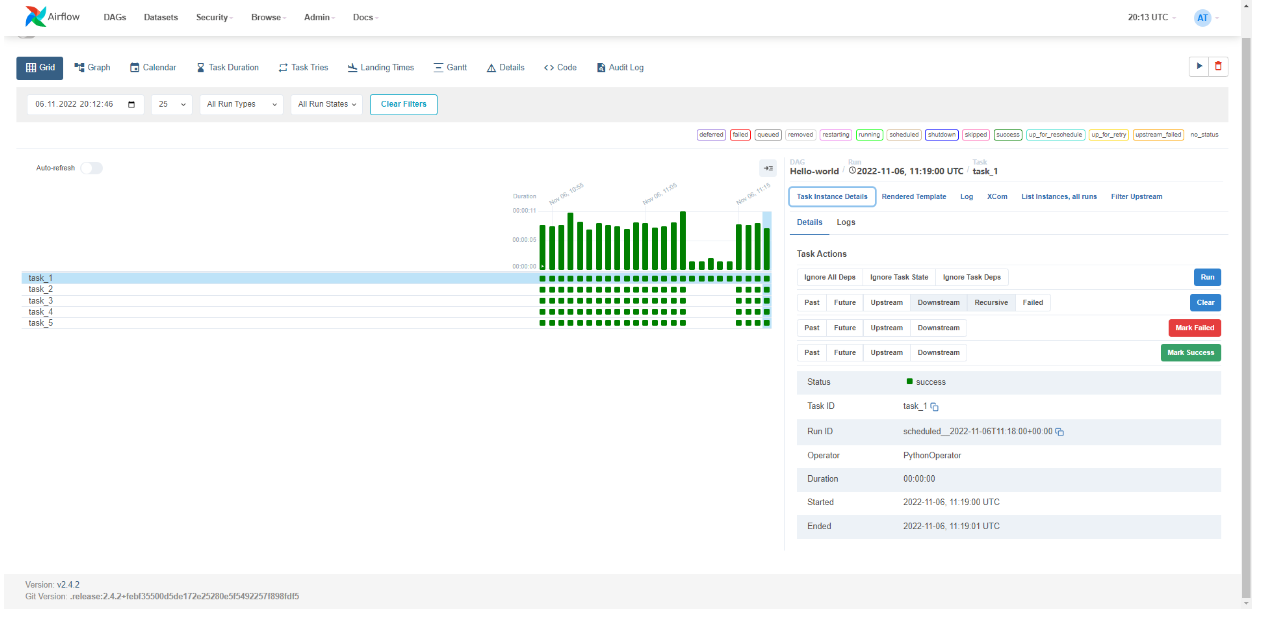

Если открыть вкладку Graph, можно заметить, что данный DAG имеет пять шагов и они выполняются последовательно друг за другом.



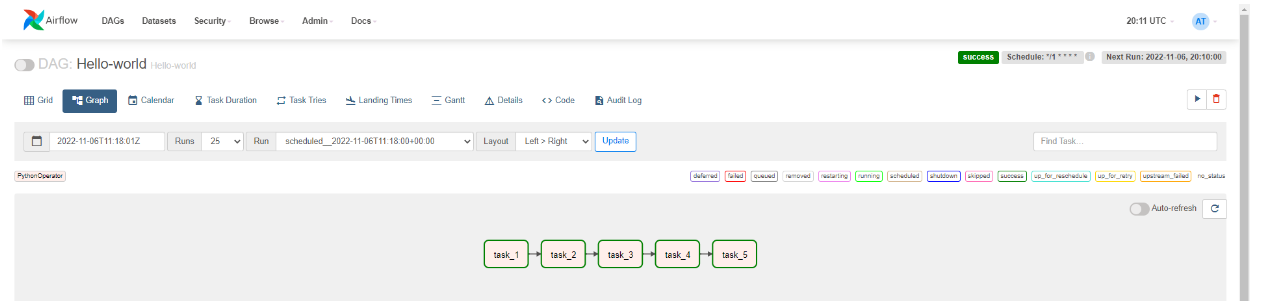

На скриншоте ниже представлен пример сохранения данных в AirFlow. Обратите внимание: данные хранятся в JSON-формате.

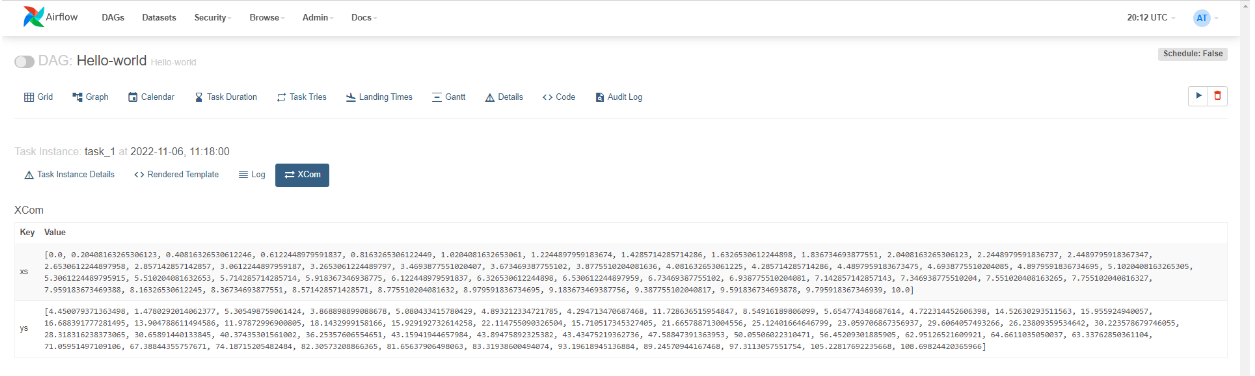

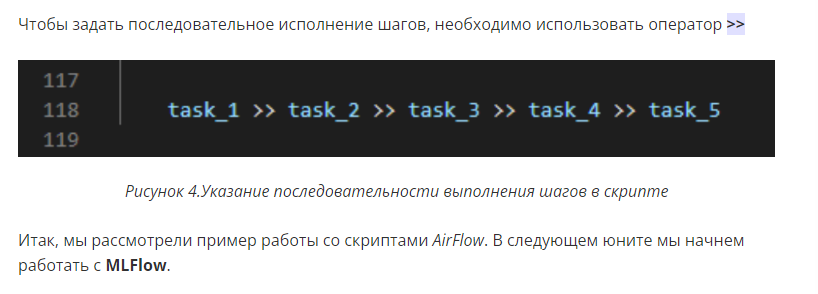